In [8]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display
tf.config.run_functions_eagerly(True)

In [9]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(25*90*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((25, 90, 256)))
    assert model.output_shape == (None, 25, 90, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 25, 90, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 50, 180, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 100, 360, 1)

    return model

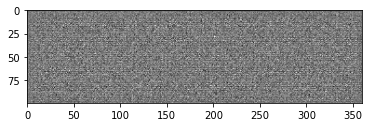

In [10]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [11]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(100,360,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=(100,360,1)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    for layer in model.layers:
      print(layer.name)
      print(layer.input_shape)
      print(layer.output_shape)

    return model

In [12]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

conv2d
(None, 100, 360, 1)
(None, 50, 180, 64)
leaky_re_lu_3
(None, 50, 180, 64)
(None, 50, 180, 64)
dropout
(None, 50, 180, 64)
(None, 50, 180, 64)
conv2d_1
(None, 50, 180, 64)
(None, 25, 90, 128)
leaky_re_lu_4
(None, 25, 90, 128)
(None, 25, 90, 128)
dropout_1
(None, 25, 90, 128)
(None, 25, 90, 128)
flatten
(None, 25, 90, 128)
(None, 288000)
dense_1
(None, 288000)
(None, 1)
tf.Tensor([[-3.751058e-05]], shape=(1, 1), dtype=float32)


# Defining loss and optimisers

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator Loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Generator Loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training

In [27]:
batch_size = 24
img_height = 100 #960
img_width = 360
#1350
data_dir = '../swir'

In [28]:
# Load the dataset and perform class-wise splitting
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

class_names = train_dataset.class_names
num_classes = len(class_names)

# Create balanced validation and testing datasets
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale')

Found 3131 files belonging to 18 classes.
Using 2505 files for training.


C:\Users\sherm\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Found 3131 files belonging to 18 classes.
Using 626 files for validation.


In [29]:
images = []
labels = []

for image_batch, label_batch in train_dataset:
    images.extend(image_batch.numpy())
    labels.extend(label_batch.numpy())

# Convert to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [30]:
train_images = images

In [31]:
train_images = train_images.reshape(train_images.shape[0], 100, 360, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [32]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000).batch(batch_size)

In [33]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [34]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      print(images.shape)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [35]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      print(image_batch.shape)
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 1 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [36]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

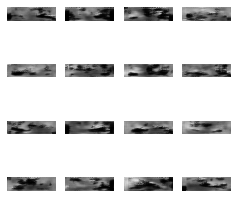

Time for epoch 41 is 844.3046917915344 sec
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)
(24, 100, 360, 1)


ResourceExhaustedError: OOM when allocating tensor with shape[24,50,180,64] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul]

In [37]:
train(train_dataset, EPOCHS)

In [54]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [55]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

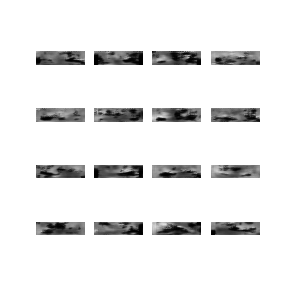

In [41]:
display_image(41)

In [42]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [45]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

ModuleNotFoundError: No module named 'tensorflow_docs'

In [46]:
!pip install -q git+https://github.com/tensorflow/docs

ERROR: Package 'tensorflow-docs' requires a different Python: 3.8.8 not in '>=3.9'


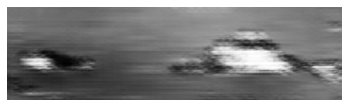

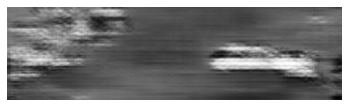

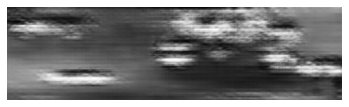

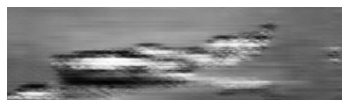

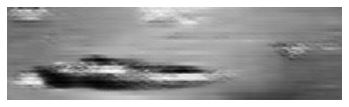

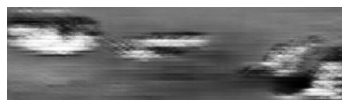

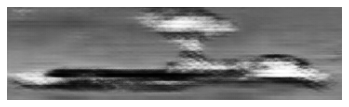

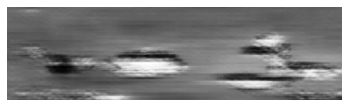

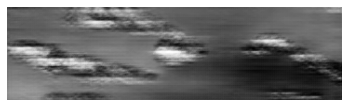

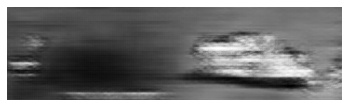

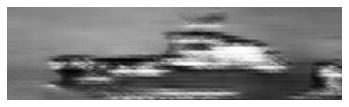

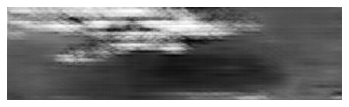

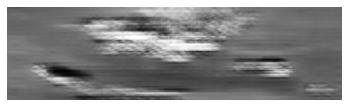

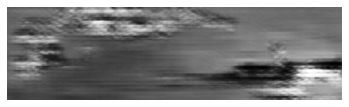

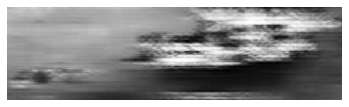

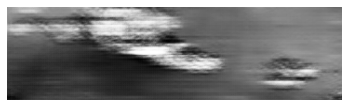

In [56]:
model = generator
test_input = seed
predictions = model(test_input, training=False)

fig = plt.figure()

for i in range(predictions.shape[0]):
    plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.show()

#plt.show()